In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import collections

from sklearn.preprocessing import LabelEncoder

import scipy.stats as stats
from scipy.stats import wilcoxon

import copy

In [3]:
log = pd.read_csv("eventsWithPhases.csv")

In [4]:
#create log with Case ID based on currentQuestion + participant

#change data type of currentQuestion from int to str
log = log.astype({'currentQuestion': str})

#combine two columns
log['case_id'] = pd.factorize(log.participant+log.currentQuestion)[0]

In [5]:
# Define conversion function
def convert_ms_to_date(milliseconds):
    date_obj = datetime.fromtimestamp(milliseconds / 1000.0)
    date_string = date_obj.strftime('%Y-%m-%d %H:%M:%S.%f')
    return date_string

# Apply conversion function to 'milliseconds' column
log['fixation_start'] = log['Fixation Start'].apply(convert_ms_to_date)
log['fixation_end'] = log['Fixation End'].apply(convert_ms_to_date)

In [6]:
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the 'tabName_element' column
log['activity'] = le.fit_transform(log['tabName_element'])

In [7]:
### log_global_search

In [8]:
#there are 614 cases, although 46 participants * 14 questions = 616 --> 2 cases are missing 
#print(len(log.case_id.unique()))

In [9]:
log

,Number,participant,FixID,Fixation X,Fixation Y,Fixation Start,Fixation End,Fixation Duration,Fixation Dispersion,SacID,...,Type3,Relevant elements labels,Relevant elements count,Relevant elements names,relevant,Phase,case_id,fixation_start,fixation_end,activity
0,0,KP1-no,1101.0,1301.2509,133.2523,5.715801e+06,5.715884e+06,83.4080,0.1208,NaN,...,Exclusiveness,['Send detailed information on final destinati...,2,"['Activity_1fk1rvd', 'Activity_0v934ow']",0,search,0,1970-01-01 02:35:15.800704,1970-01-01 02:35:15.884111,82
1,1,KP1-no,1102.0,577.2880,-37.4236,5.716709e+06,5.716834e+06,124.9670,0.3481,NaN,...,Exclusiveness,['Send detailed information on final destinati...,2,"['Activity_1fk1rvd', 'Activity_0v934ow']",0,search,0,1970-01-01 02:35:16.708983,1970-01-01 02:35:16.833950,82
2,2,KP1-no,1103.0,453.3125,-42.5000,5.716884e+06,5.716951e+06,66.6000,0.2288,NaN,...,Exclusiveness,['Send detailed information on final destinati...,2,"['Activity_1fk1rvd', 'Activity_0v934ow']",0,search,0,1970-01-01 02:35:16.883977,1970-01-01 02:35:16.950577,82
3,3,KP1-no,1104.0,579.9746,-80.0503,5.717900e+06,5.717984e+06,83.3050,1.5229,NaN,...,Exclusiveness,['Send detailed information on final destinati...,2,"['Activity_1fk1rvd', 'Activity_0v934ow']",0,search,0,1970-01-01 02:35:17.900487,1970-01-01 02:35:17.983792,82
4,4,KP1-no,1105.0,647.4488,-46.5585,5.718375e+06,5.718484e+06,108.3100,0.2081,NaN,...,Exclusiveness,['Send detailed information on final destinati...,2,"['Activity_1fk1rvd', 'Activity_0v934ow']",0,search,0,1970-01-01 02:35:18.375424,1970-01-01 02:35:18.483734,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174696,174696,SP11-no,5752.0,789.3538,186.0428,9.295871e+06,9.296079e+06,208.2810,0.2594,NaN,...,Data-based Routing,"['Container [in transition]', 'Collect contain...",3,"['DataObjectReference_09inboe', 'Activity_0qpe...",0,NaN,613,1970-01-01 03:34:55.871112,1970-01-01 03:34:56.079393,650
174697,174697,SP11-no,5753.0,1229.2347,118.4895,9.296179e+06,9.296563e+06,383.2750,0.3156,NaN,...,Data-based Routing,"['Container [in transition]', 'Collect contain...",3,"['DataObjectReference_09inboe', 'Activity_0qpe...",0,NaN,613,1970-01-01 03:34:56.179382,1970-01-01 03:34:56.562657,605
174698,174698,SP11-no,5754.0,1282.5789,124.7105,9.296621e+06,9.296779e+06,158.3300,0.2466,NaN,...,Data-based Routing,"['Container [in transition]', 'Collect contain...",3,"['DataObjectReference_09inboe', 'Activity_0qpe...",0,NaN,613,1970-01-01 03:34:56.620999,1970-01-01 03:34:56.779329,605
174699,174699,SP11-no,5755.0,911.5417,199.0000,9.296846e+06,9.296946e+06,100.0035,0.1728,NaN,...,Data-based Routing,"['Container [in transition]', 'Collect contain...",3,"['DataObjectReference_09inboe', 'Activity_0qpe...",0,NaN,613,1970-01-01 03:34:56.845958,1970-01-01 03:34:56.945961,650


In [10]:
#Select only Control-flow questions
log_select = log[['case_id', 'fixation_start', 'activity', 'Phase', 'Type1', 'Type2', 'Type3', 'Fixation Duration', 'participant']]
log_tasks = log_select.loc[log_select['Type2'] == 'Control-flow']
log_tasks['taskType'] = log_tasks['Type1'] + log_tasks['Type3']

log_global_search = log_tasks.loc[(log_tasks['Type1'] == 'Global') & (log_tasks['Phase'] == 'search')]
log_global_inference = log_tasks.loc[(log_tasks['Type1'] == 'Global') & (log_tasks['Phase'] == 'inference')]
log_local_search = log_tasks.loc[(log_tasks['Type1'] == 'Local') & (log_tasks['Phase'] == 'search')]
log_local_inference = log_tasks.loc[(log_tasks['Type1'] == 'Local') & (log_tasks['Phase'] == 'inference')]


#Create trace logs
logVar_global_search = log_global_search.groupby(['case_id'])['activity'].apply(list).reset_index()
logVar_global_inference = log_global_inference.groupby(['case_id'])['activity'].apply(list).reset_index()
logVar_local_search = log_local_search.groupby(['case_id'])['activity'].apply(list).reset_index()
logVar_local_inference = log_local_inference.groupby(['case_id'])['activity'].apply(list).reset_index()

C:\Users\la1949\AppData\Local\Temp\ipykernel_26172\3806467676.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_tasks['taskType'] = log_tasks['Type1'] + log_tasks['Type3']


In [11]:
#log['activity'] = le.fit_transform(log['tabName_element'])
#log_select = log[['case_id', 'fixation_start', 'activity', 'Phase', 'Type1', 'Type2', 'Type3', 'Fixation Duration', 'participant']]
#log_tasks = log_select.loc[log_select['Type2'] == 'Control-flow']
#log_tasks['taskType'] = log_tasks['Type1'] + log_tasks['Type3']

log_global = log_tasks.loc[(log_tasks['Type1'] == 'Global')]
log_local = log_tasks.loc[(log_tasks['Type1'] == 'Local')]


logVar_global = log_global.groupby(['case_id'])['activity'].apply(list).reset_index()
logVar_local = log_local.groupby(['case_id'])['activity'].apply(list).reset_index()

In [12]:
log_global_search_participant = log_global_search.groupby(['case_id'])['participant'].apply(list).reset_index()
log_global_search_participant['participant'] = log_global_search_participant['participant'].apply(lambda x: set(x))
log_global_search_participant['participant'] = log_global_search_participant['participant'].apply(lambda x: ''.join(x))
logVar_global_search = pd.merge(logVar_global_search, log_global_search_participant, on='case_id')


log_global_inference_participant = log_global_inference.groupby(['case_id'])['participant'].apply(list).reset_index()
log_global_inference_participant['participant'] = log_global_inference_participant['participant'].apply(lambda x: set(x))
log_global_inference_participant['participant'] = log_global_inference_participant['participant'].apply(lambda x: ''.join(x))
logVar_global_inference = pd.merge(logVar_global_inference, log_global_inference_participant, on='case_id')

log_local_search_participant = log_local_search.groupby(['case_id'])['participant'].apply(list).reset_index()
log_local_search_participant['participant'] = log_local_search_participant['participant'].apply(lambda x: set(x))
log_local_search_participant['participant'] = log_local_search_participant['participant'].apply(lambda x: ''.join(x))
logVar_local_search = pd.merge(logVar_local_search, log_local_search_participant, on='case_id')

log_local_inference_participant = log_local_inference.groupby(['case_id'])['participant'].apply(list).reset_index()
log_local_inference_participant['participant'] = log_local_inference_participant['participant'].apply(lambda x: set(x))
log_local_inference_participant['participant'] = log_local_inference_participant['participant'].apply(lambda x: ''.join(x))
logVar_local_inference = pd.merge(logVar_local_inference, log_local_inference_participant, on='case_id')


In [13]:
log_global_participant = log_global.groupby(['case_id'])['participant'].apply(list).reset_index()
log_global_participant['participant'] = log_global_participant['participant'].apply(lambda x: set(x))
log_global_participant['participant'] = log_global_participant['participant'].apply(lambda x: ''.join(x))
logVar_global = pd.merge(logVar_global, log_global_participant, on='case_id')

log_local_participant = log_local.groupby(['case_id'])['participant'].apply(list).reset_index()
log_local_participant['participant'] = log_local_participant['participant'].apply(lambda x: set(x))
log_local_participant['participant'] = log_local_participant['participant'].apply(lambda x: ''.join(x))
logVar_local = pd.merge(logVar_local, log_local_participant, on='case_id')

In [14]:
log_tasks.Phase.unique() # --> why nan?

array(['search', 'inference', nan], dtype=object)

In [15]:
# Calculate Entropy

def summary_statistic(window):
    counter = collections.Counter(window)  # count the occurrences of each element in the window
    freqs = np.array(list(counter.values()))  # extract the frequency counts and store them as a numpy array
    freqs = freqs / freqs.sum()  # normalize the frequencies to obtain a probability distribution
    entropy = -np.sum(freqs * np.log(freqs)) / np.log(2) # compute the entropy of the probability distribution
    return entropy


def avg_trace_entropy(log):
    traces = log["trace_variant"]
    for i in traces:
        #print(i)
        print(summary_statistic(i))

#Example
#a = ["A", "A", "A", "A", "B"]        
#summary_statistic(a)

In [16]:
# Add entropy to df

logVar_global_search['trace_entropy'] = logVar_global_search['activity'].apply(summary_statistic)
logVar_global_inference['trace_entropy'] = logVar_global_inference['activity'].apply(summary_statistic)
logVar_local_search['trace_entropy'] = logVar_local_search['activity'].apply(summary_statistic)
logVar_local_inference['trace_entropy'] = logVar_local_inference['activity'].apply(summary_statistic)

In [17]:
logVar_global_search

,case_id,activity,participant,trace_entropy
0,5,"[90, 82, 183, 82, 82, 82, 82, 82, 183, 77, 75,...",KP1-no,5.137653
1,9,"[82, 82, 82, 110, 82, 179, 82, 82, 82, 82, 82,...",KP1-no,2.981627
2,18,"[89, 50, 56, 181, 181, 181, 181, 181, 181, 181...",KP10-no,6.390246
3,19,"[93, 50, 183, 59, 183, 183, 183, 183, 183, 183...",KP10-no,4.174346
4,23,"[88, 110, 179, 179, 179, 179, 179, 179, 112, 7...",KP10-no,5.793971
...,...,...,...,...
151,592,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8...",SP9-no,4.140865
152,597,"[179, 82, 179, 82, 82, 82, 82, 82, 82, 82, 82,...",SP9-no,5.471406
153,598,"[82, 82, 82, 82, 82, 82, 82, 50, 50, 3, 27, 32...",SP9-no,5.631224
154,605,"[50, 181, 181, 181, 82, 181, 56, 181, 113, 181...",SP11-no,5.000970


In [18]:
#logVar_global_search[['trace_entropy']
logVar_global_search_agg = logVar_global_search.groupby(['participant']).agg({'trace_entropy':'mean'})
logVar_global_inference_agg = logVar_global_inference.groupby(['participant']).agg({'trace_entropy':'mean'})
logVar_local_search_agg = logVar_local_search.groupby(['participant']).agg({'trace_entropy':'mean'})
logVar_local_inference_agg = logVar_local_inference.groupby(['participant']).agg({'trace_entropy':'mean'})

In [19]:
logVar_global_search

,case_id,activity,participant,trace_entropy
0,5,"[90, 82, 183, 82, 82, 82, 82, 82, 183, 77, 75,...",KP1-no,5.137653
1,9,"[82, 82, 82, 110, 82, 179, 82, 82, 82, 82, 82,...",KP1-no,2.981627
2,18,"[89, 50, 56, 181, 181, 181, 181, 181, 181, 181...",KP10-no,6.390246
3,19,"[93, 50, 183, 59, 183, 183, 183, 183, 183, 183...",KP10-no,4.174346
4,23,"[88, 110, 179, 179, 179, 179, 179, 179, 112, 7...",KP10-no,5.793971
...,...,...,...,...
151,592,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8...",SP9-no,4.140865
152,597,"[179, 82, 179, 82, 82, 82, 82, 82, 82, 82, 82,...",SP9-no,5.471406
153,598,"[82, 82, 82, 82, 82, 82, 82, 50, 50, 3, 27, 32...",SP9-no,5.631224
154,605,"[50, 181, 181, 181, 82, 181, 56, 181, 113, 181...",SP11-no,5.000970


In [27]:
#Check whether the entropy during search is always higher for global than for local tasks for each participant on average

entropy_search_G_L = pd.merge(logVar_global_search_agg, logVar_local_search_agg, on='participant')

entropy_search_G_L['Glo > Loc'] = entropy_search_G_L.apply(lambda x: True if x['trace_entropy_x'] > x['trace_entropy_y'] else (x['trace_entropy_x'],x['trace_entropy_y']), axis=1)
entropy_search_G_L

,trace_entropy_x,trace_entropy_y,Glo > Loc
participant,,,
KP1-no,4.059640,4.270510,"(4.059640125816222, 4.270510293360215)"
KP10-no,5.340744,3.401842,True
KP11-no,4.607692,5.122522,"(4.607692053874793, 5.1225224821285655)"
KP12-no,3.253024,2.480034,True
KP13-no,4.665917,4.471349,True
KP14-no,5.220655,4.193652,True
KP15-no,4.669830,4.159634,True
KP16-no,4.760174,4.503371,True
KP17-no,4.575482,4.469087,True


In [30]:
entropy_search_G_L.loc[entropy_search_G_L['Glo > Loc'] == True].count()

trace_entropy_x    37
trace_entropy_y    37
Glo > Loc          37
dtype: int64

In [31]:
#Check whether the entropy during inference is always higher for global than for local tasks for each participant on average

entropy_inference_G_L = pd.merge(logVar_global_inference_agg, logVar_local_inference_agg, on='participant')

entropy_inference_G_L['Glo > Loc'] = entropy_inference_G_L.apply(lambda x: True if x['trace_entropy_x'] > x['trace_entropy_y'] else (x['trace_entropy_x'],x['trace_entropy_y']), axis=1)
entropy_inference_G_L

,trace_entropy_x,trace_entropy_y,Glo > Loc
participant,,,
KP1-no,2.603273,3.901582,"(2.603273145106972, 3.9015824227286537)"
KP10-no,5.102994,3.409047,True
KP11-no,4.305077,3.175313,True
KP12-no,4.498240,1.976389,True
KP13-no,4.138284,2.662335,True
KP14-no,4.807260,3.317401,True
KP15-no,5.911515,3.277684,True
KP16-no,4.357728,2.736286,True
KP17-no,5.011406,3.684460,True


In [32]:
entropy_inference_G_L.loc[entropy_inference_G_L['Glo > Loc'] == True].count()

trace_entropy_x    43
trace_entropy_y    43
Glo > Loc          43
dtype: int64

In [20]:
#######################
### Mean
#######################

print('global search:', logVar_global_search_agg.mean())
print('global inference:', logVar_global_inference_agg.mean())
print('local search:', logVar_local_search_agg.mean())
print('local inference:', logVar_local_inference_agg.mean())

global search: trace_entropy    4.650152
dtype: float64
global inference: trace_entropy    4.708551
dtype: float64
local search: trace_entropy    3.939616
dtype: float64
local inference: trace_entropy    3.153731
dtype: float64


In [25]:
#######################
### Std
#######################

print('global search:', logVar_global_search_agg.std())
print('global inference:', logVar_global_inference_agg.std())
print('local search:', logVar_local_search_agg.std())
print('local inference:', logVar_local_inference_agg.std())

global search: trace_entropy    0.472993
dtype: float64
global inference: trace_entropy    0.626115
dtype: float64
local search: trace_entropy    0.685524
dtype: float64
local inference: trace_entropy    0.445638
dtype: float64


In [21]:
#global
stats.wilcoxon(logVar_global_search_agg['trace_entropy'], logVar_global_inference_agg['trace_entropy'],alternative='greater')

WilcoxonResult(statistic=462.0, pvalue=0.6506866179365716)

In [22]:
#local
stats.wilcoxon(logVar_local_search_agg['trace_entropy'], logVar_local_inference_agg['trace_entropy'],alternative='greater')

WilcoxonResult(statistic=930.0, pvalue=5.761705779150361e-09)

In [23]:
#search
stats.wilcoxon(logVar_local_search_agg['trace_entropy'], logVar_global_search_agg['trace_entropy'],alternative='less')

WilcoxonResult(statistic=67.0, pvalue=1.2301768492761767e-08)

In [24]:
#inference
stats.wilcoxon(logVar_local_inference_agg['trace_entropy'], logVar_global_inference_agg['trace_entropy'],alternative='less')

WilcoxonResult(statistic=9.0, pvalue=1.8758328224066645e-12)

In [27]:
# --> difference in entropy significant

## Time Series

In [311]:
logVar_local

,case_id,activity,participant
0,0,"[82, 82, 82, 82, 82, 177, 82, 82, 82, 82, 82, ...",KP1-no
1,6,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8...",KP1-no
2,7,"[86, 82, 82, 82, 82, 178, 178, 82, 82, 82, 82,...",KP1-no
3,8,"[82, 82, 67, 82, 82, 143, 145, 67, 50, 25, 82,...",KP1-no
4,14,"[52, 104, 177, 82, 82, 177, 104, 104, 104, 106...",KP10-no
...,...,...,...
170,595,"[148, 178, 178, 82, 82, 82, 82, 82, 82, 82, 82...",SP9-no
171,596,"[100, 195, 82, 82, 82, 82, 82, 195, 195, 82, 8...",SP9-no
172,607,"[82, 82, 82, 102, 175, 175, 175, 175, 175, 175...",SP11-no
173,608,"[86, 86, 82, 108, 109, 86, 178, 86, 178, 108, ...",SP11-no


In [238]:
logVar_local_search

,case_id,activity,participant,trace_entropy
0,0,"[82, 82, 82, 82, 82, 177, 82, 82, 82, 82, 82, ...",KP1-no,4.238754
1,6,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8...",KP1-no,4.302267
2,14,"[52, 104, 177, 82, 82, 177, 104, 104, 104, 106...",KP10-no,4.053269
3,20,"[83, 50, 103, 175, 175, 175, 175, 175, 51, 175...",KP10-no,3.327401
4,21,"[53, 53, 178, 108, 82, 178, 82, 178, 178, 53, ...",KP10-no,4.042727
...,...,...,...,...
162,595,"[148, 178, 178, 82, 82, 82, 82, 82, 82, 82, 82...",SP9-no,3.572695
163,596,"[100, 195, 82, 82, 82, 82, 82, 195, 195, 82, 8...",SP9-no,5.432558
164,607,"[82, 82, 82, 102, 175, 175, 175, 175, 175, 175...",SP11-no,3.165035
165,608,"[86, 86, 82, 108, 109, 86, 178, 86, 178, 108, ...",SP11-no,3.658204


In [363]:
#logVar_global_search_caseID = logVar_global_search.loc[(logVar_global_search['case_id'] == 23)]
cut = len(logVar_local_search['activity'][164])
#cut = len(logVar_global_search_caseID['activity'])
cut
#logVar_global_search_caseID['activity']

92

([<matplotlib.axis.XTick at 0x17710d80bb0>,
 [Text(0, 0, '0'),
  Text(25, 0, '25'),
  Text(50, 0, '50'),
  Text(75, 0, '75'),
  Text(100, 0, '100'),
  Text(125, 0, '125'),
  Text(150, 0, '150'),
  Text(175, 0, '175')])

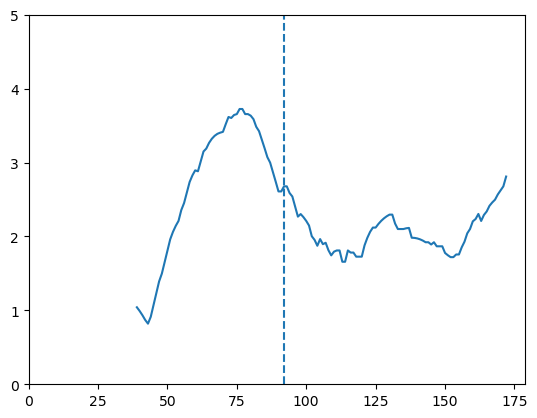

In [365]:
#Entropy Evolution Local Question
window = 40

x_ser = pd.Series(logVar_local["activity"][172])
y_win = x_ser.rolling(window).apply(summary_statistic)


y_win.plot.line(x='lab', y='val', rot=0)
plt.axvline(x=cut, ls='--')
#plt.xticks([0,20,40,60,80,100])
plt.yticks([0,1.0,2.0,3.0,4.0,5.0])
plt.xticks([0,25, 50, 75, 100, 125, 150, 175])

In [133]:
def newFixation(pandaSeries):
    x = []
    new = 0
    newSeries = []
    for i in range(len(pandaSeries)):
        if pandaSeries[i] not in set(x):
            #print(pandaSeries[i])
            #print(x)
            x.append(pandaSeries[i])
            new += 1
            newSeries.append(new)
        else:
            newSeries.append(new)
    return newSeries
            

#list(x_ser)

([<matplotlib.axis.XTick at 0x17730e852b0>,
 [Text(0, 0, '0'),
  Text(25, 0, '25'),
  Text(50, 0, '50'),
  Text(75, 0, '75'),
  Text(100, 0, '100'),
  Text(125, 0, '125'),
  Text(150, 0, '150'),
  Text(175, 0, '175')])

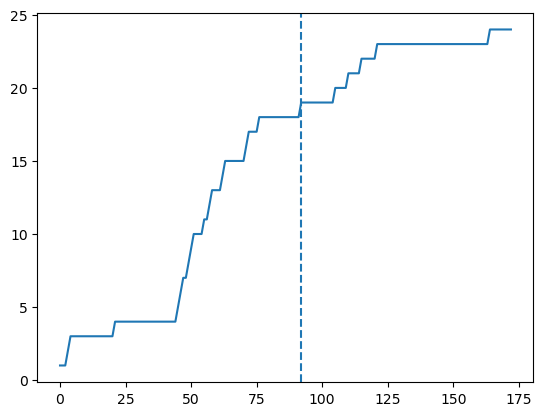

In [321]:
newSeries = newFixation(x_ser)

newSeries_pd = pd.Series(newSeries)
newSeries_pd.plot.line(x='lab', y='val', rot=0)
plt.axvline(x=cut, ls='--')
plt.xticks([0,25, 50, 75, 100, 125, 150, 175])

In [61]:
logVar_global

,case_id,activity,participant
0,4,"[82, 82, 82, 181, 82, 82, 82, 82, 82, 82, 181,...",KP1-no
1,5,"[90, 82, 183, 82, 82, 82, 82, 82, 183, 77, 75,...",KP1-no
2,9,"[82, 82, 82, 110, 82, 179, 82, 82, 82, 82, 82,...",KP1-no
3,10,"[82, 82, 182, 57, 57, 82, 82, 82, 82, 82, 82, ...",KP1-no
4,18,"[89, 50, 56, 181, 181, 181, 181, 181, 181, 181...",KP10-no
...,...,...,...
170,597,"[179, 82, 179, 82, 82, 82, 82, 82, 82, 82, 82,...",SP9-no
171,598,"[82, 82, 82, 82, 82, 82, 82, 50, 50, 3, 27, 32...",SP9-no
172,605,"[50, 181, 181, 181, 82, 181, 56, 181, 113, 181...",SP11-no
173,606,"[82, 59, 120, 122, 183, 120, 120, 183, 59, 183...",SP11-no


In [171]:
logVar_global_search

,case_id,activity,participant,trace_entropy
0,5,"[90, 82, 183, 82, 82, 82, 82, 82, 183, 77, 75,...",KP1-no,5.137653
1,9,"[82, 82, 82, 110, 82, 179, 82, 82, 82, 82, 82,...",KP1-no,2.981627
2,18,"[89, 50, 56, 181, 181, 181, 181, 181, 181, 181...",KP10-no,6.390246
3,19,"[93, 50, 183, 59, 183, 183, 183, 183, 183, 183...",KP10-no,4.174346
4,23,"[88, 110, 179, 179, 179, 179, 179, 179, 112, 7...",KP10-no,5.793971
...,...,...,...,...
151,592,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8...",SP9-no,4.140865
152,597,"[179, 82, 179, 82, 82, 82, 82, 82, 82, 82, 82,...",SP9-no,5.471406
153,598,"[82, 82, 82, 82, 82, 82, 82, 50, 50, 3, 27, 32...",SP9-no,5.631224
154,605,"[50, 181, 181, 181, 82, 181, 56, 181, 113, 181...",SP11-no,5.000970


In [325]:
cut = len(logVar_global_search['activity'][155])
#cut = len(logVar_global_search_caseID['activity'])
cut

166

([<matplotlib.axis.YTick at 0x17730ffd310>,
 [Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5')])

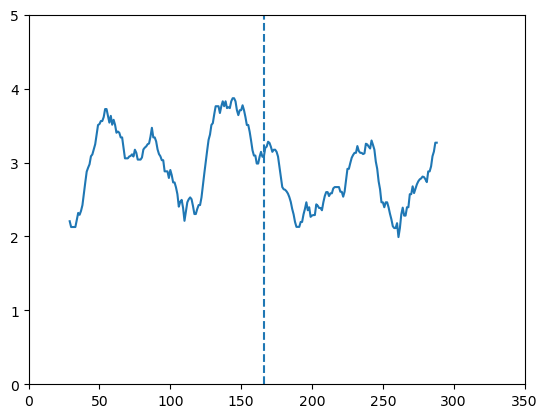

In [326]:
#Entropy Evolution Global Question
window = 30

x_ser = pd.Series(logVar_global["activity"][173])
y_win = x_ser.rolling(window).apply(summary_statistic)


y_win.plot.line(x='lab', y='val', rot=0)
plt.axvline(x=cut, ls='--')
plt.xticks([0,50, 100, 150, 200, 250, 300, 350])
plt.yticks([0,1.0,2.0,3.0,4.0,5.0])

In [214]:
#logVar_global.loc[(logVar_global['case_id'] == 5)]
logVar_global.iloc[1]

case_id                                                        5
activity       [90, 82, 183, 82, 82, 82, 82, 82, 183, 77, 75,...
participant                                               KP1-no
Name: 1, dtype: object

([<matplotlib.axis.YTick at 0x1772e559820>,
 [Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5')])

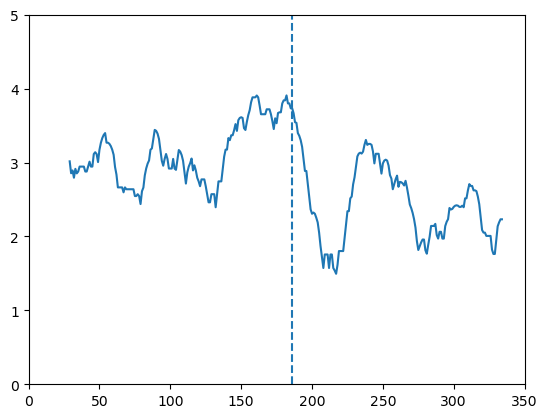

In [292]:
#Entropy Evolution Global Question
window = 30

x_ser = pd.Series(logVar_global["activity"][1])
y_win = x_ser.rolling(window).apply(summary_statistic)


y_win.plot.line(x='lab', y='val', rot=0)
plt.axvline(x=cut, ls='--')
plt.xticks([0,50, 100, 150, 200, 250, 300, 350])
plt.yticks([0,1.0,2.0,3.0,4.0,5.0])

([<matplotlib.axis.XTick at 0x1772a588e20>,
 [Text(0, 0, '0'),
  Text(50, 0, '50'),
  Text(100, 0, '100'),
  Text(150, 0, '150'),
  Text(200, 0, '200'),
  Text(250, 0, '250'),
  Text(300, 0, '300'),
  Text(350, 0, '350')])

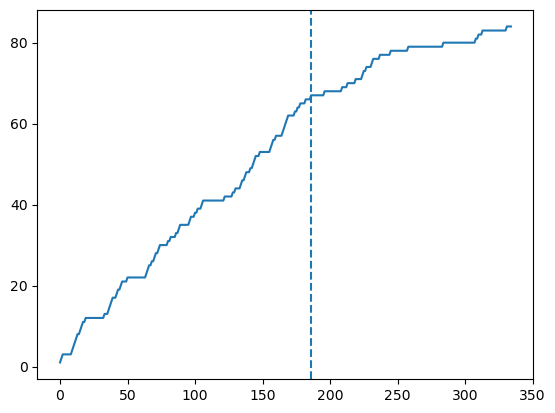

In [232]:
newSeries = newFixation(x_ser)

newSeries_pd = pd.Series(newSeries)
newSeries_pd.plot.line(x='lab', y='val', rot=0)
plt.axvline(x=cut, ls='--')
plt.xticks([0,50, 100, 150, 200, 250, 300, 350])

In [219]:
newSeries_pd

0       1
1       2
2       3
3       3
4       3
       ..
330    83
331    84
332    84
333    84
334    84
Length: 335, dtype: int64

In [220]:
y_win

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
330    2.070880
331    2.179593
332    2.219241
333    2.219241
334    2.070880
Length: 335, dtype: float64

In [152]:
df_plot = pd.concat([newSeries_pd, y_win], axis=1)

In [225]:
IndexList = range(0, 335)

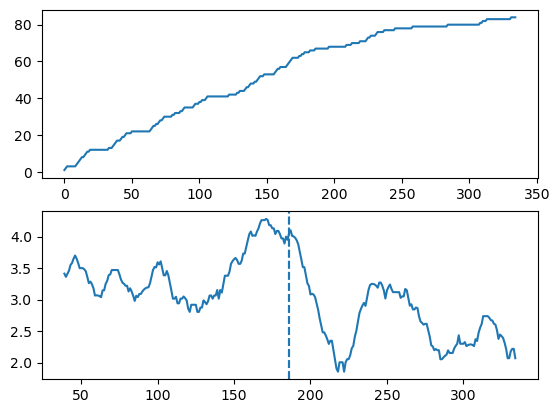

In [227]:
#df_plot
fig, axs = plt.subplots(2)
axs[0].plot(IndexList, newSeries_pd)
plt.axvline(x=cut, ls='--')
axs[1].plot(IndexList, y_win)
plt.axvline(x=cut, ls='--')

In [ ]:
axes = df.plot.line(subplots=True)

type(axes)

## Process Maps

In [327]:
#import os
import pm4py

In [328]:
log = pd.read_csv("eventsWithPhases.csv")

In [329]:
#create log with Case ID based on currentQuestion + participant

#change data type of currentQuestion from int to str
log = log.astype({'currentQuestion': str})

#combine two columns
log['case_id'] = pd.factorize(log.participant+log.currentQuestion)[0]

In [330]:
# Define conversion function
def convert_ms_to_date(milliseconds):
    date_obj = datetime.fromtimestamp(milliseconds / 1000.0)
    date_string = date_obj.strftime('%Y-%m-%d %H:%M:%S.%f')
    return date_string

# Apply conversion function to 'milliseconds' column
log['fixation_start'] = log['Fixation Start'].apply(convert_ms_to_date)
log['fixation_end'] = log['Fixation End'].apply(convert_ms_to_date)

In [331]:
# Fit and transform the 'tabName_element' column
log['tabName_element'] = le.fit_transform(log['tabName_element'])

In [332]:
#Select only Control-flow questions
log_select = log[['case_id', 'fixation_start', 'tabName_element', 'Phase', 'Type1', 'Type2', 'Type3', 'Fixation Duration']]
log_tasks = log_select.loc[log_select['Type2'] == 'Control-flow']
log_tasks['taskType'] = log_tasks['Type1'] + log_tasks['Type3']

log_global_search = log_tasks.loc[(log_tasks['Type1'] == 'Global') & (log_tasks['Phase'] == 'search')]
log_global_inference = log_tasks.loc[(log_tasks['Type1'] == 'Global') & (log_tasks['Phase'] == 'inference')]
log_local_search = log_tasks.loc[(log_tasks['Type1'] == 'Local') & (log_tasks['Phase'] == 'search')]
log_local_inference = log_tasks.loc[(log_tasks['Type1'] == 'Local') & (log_tasks['Phase'] == 'inference')]

C:\Users\la1949\AppData\Local\Temp\ipykernel_11236\2729525869.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_tasks['taskType'] = log_tasks['Type1'] + log_tasks['Type3']


## Example Local case_id = 6

In [333]:
#Local-SEARCH
log_csv_LS = pm4py.format_dataframe(log_local_search, case_id='case_id', activity_key='tabName_element', timestamp_key='fixation_start', timest_format='%Y-%m-%d %H:%M:%S.%f')
start_activities_LS = pm4py.get_start_activities(log_csv_LS)
end_activities_LS = pm4py.get_end_activities(log_csv_LS)

#Local-INFERENCE
log_csv_LI = pm4py.format_dataframe(log_local_inference, case_id='case_id', activity_key='tabName_element', timestamp_key='fixation_start', timest_format='%Y-%m-%d %H:%M:%S.%f')
start_activities_LI = pm4py.get_start_activities(log_csv_LI)
end_activities_LI = pm4py.get_end_activities(log_csv_LI)

C:\Users\la1949\AppData\Local\Temp\ipykernel_11236\1085341559.py:2: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  log_csv_LS = pm4py.format_dataframe(log_local_search, case_id='case_id', activity_key='tabName_element', timestamp_key='fixation_start', timest_format='%Y-%m-%d %H:%M:%S.%f')
C:\Users\la1949\Anaconda3\envs\pm4py\lib\site-packages\pm4py\utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
C:\Users\la1949\Anaconda3\envs\pm4py\lib\site-packages\pm4py\utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [334]:
log_csv_LS['case_id'].unique()

array([  0, 104, 105, 112, 118, 119, 120, 126, 132, 133, 134,  14, 140,
       146, 147, 148, 154, 160, 161, 162, 168, 174, 175, 176, 182, 188,
       189, 190, 196,  20, 202, 203, 204,  21, 210, 216, 217, 218,  22,
       224, 230, 231, 232, 238, 244, 245, 246, 252, 258, 259, 260, 266,
       272, 273, 274,  28, 280, 286, 287, 288, 294, 300, 301, 302, 308,
       314, 315, 316, 322, 328, 329, 330, 336,  34, 342, 343, 344,  35,
       350, 356, 357, 358,  36, 364, 370, 371, 372, 378, 384, 385, 386,
       392, 398, 399, 400, 406, 413, 414,  42, 420, 426, 427, 428, 434,
       440, 448, 454, 462, 468, 469, 470, 476,  48, 482, 483, 484,  49,
       490, 496, 497, 498,  50, 504, 510, 511, 512, 518, 524, 525, 526,
       532, 538, 539, 540, 546, 552, 553, 554,  56, 560, 566, 567, 568,
       574, 580, 581, 582, 588, 594, 595, 596,   6, 607, 608, 609,  62,
        63,  64,  70,  76,  77,  78,  84,  90,  91,  92,  98], dtype=int64)

In [352]:
#Select log for a single participant - LOCAL

case = 607 #Select case_id
Local_S_Case = log_csv_LS.loc[log_csv_LS['case_id']== case] # Search
Local_I_Case = log_csv_LI.loc[log_csv_LI['case_id']== case] # Inference

pm4py.write_xes(Local_S_Case, 'log_csv_LS.xes')
pm4py.write_xes(Local_I_Case, 'log_csv_LI.xes')

exporting log, completed traces :: 100%|██████████| 1/1 [00:00<00:00, 64.01it/s]


parsing log, completed traces :: 100%|██████████| 1/1 [00:00<00:00, 63.99it/s]
C:\Users\la1949\AppData\Local\Temp\ipykernel_11236\3450383286.py:4: DeprecatedWarning: discover_dfg is deprecated as of 2.3.0 and will be removed in 2.4.0. this method will be replaced by the discover_dfg_typed function(). Please adapt your code to use pm4py.discover_dfg_typed()
  dfg, start_activities_LS, end_activities_LS = pm4py.discover_dfg(log_xes_LS)


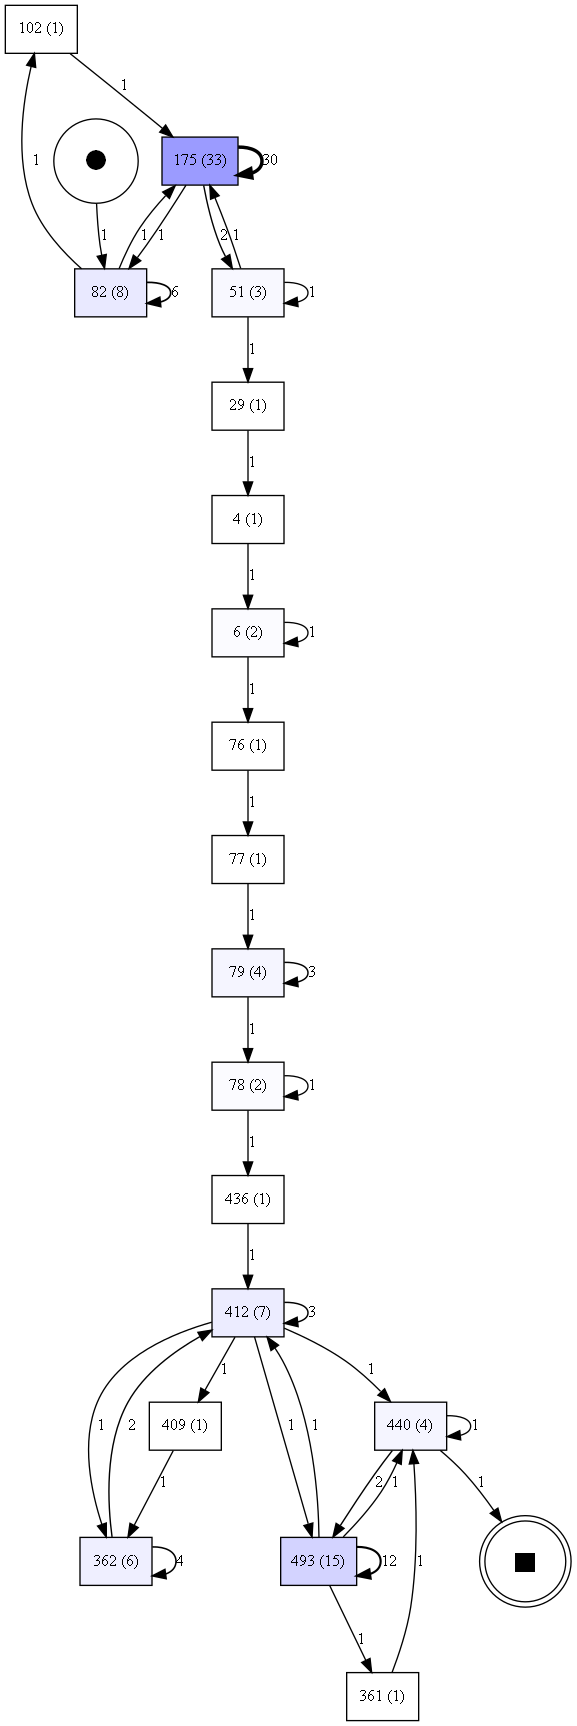

In [353]:
# Local Search

log_xes_LS = pm4py.read_xes("log_csv_LS.xes")
dfg, start_activities_LS, end_activities_LS = pm4py.discover_dfg(log_xes_LS)
pm4py.vis.view_dfg(dfg, start_activities_LS, end_activities_LS)

parsing log, completed traces :: 100%|██████████| 1/1 [00:00<00:00, 64.00it/s]
C:\Users\la1949\AppData\Local\Temp\ipykernel_11236\4218778671.py:4: DeprecatedWarning: discover_dfg is deprecated as of 2.3.0 and will be removed in 2.4.0. this method will be replaced by the discover_dfg_typed function(). Please adapt your code to use pm4py.discover_dfg_typed()
  dfg, start_activities_LI, end_activities_LI = pm4py.discover_dfg(log_xes_LI)


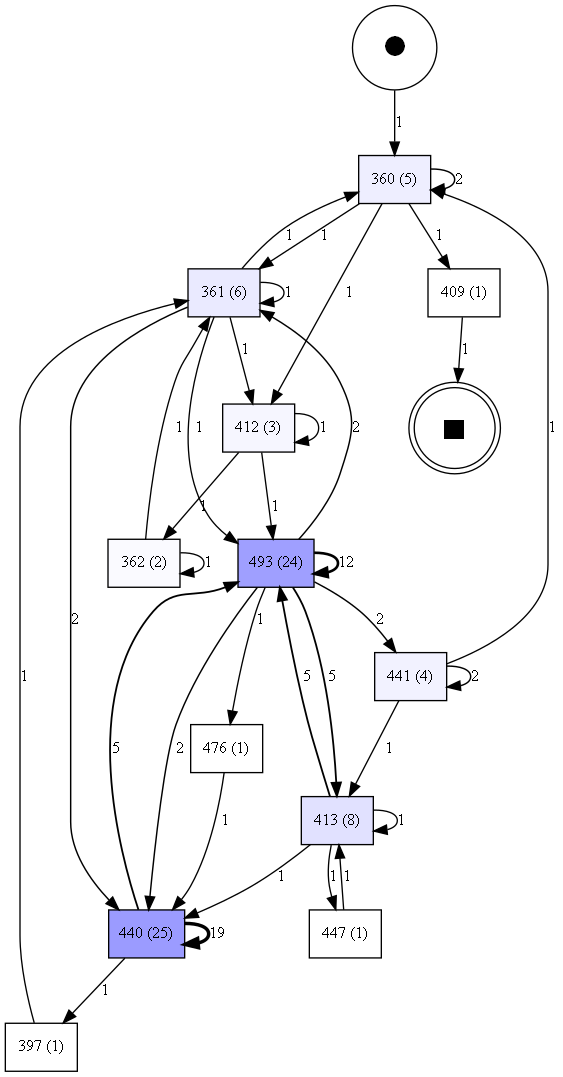

In [354]:
# Local Inference

log_xes_LI = pm4py.read_xes("log_csv_LI.xes")
dfg, start_activities_LI, end_activities_LI = pm4py.discover_dfg(log_xes_LI)
pm4py.vis.view_dfg(dfg, start_activities_LI, end_activities_LI)

## Example Global case_id = 66

In [355]:
#GLOBAL-SEARCH
log_csv_GS = pm4py.format_dataframe(log_global_search, case_id='case_id', activity_key='tabName_element', timestamp_key='fixation_start', timest_format='%Y-%m-%d %H:%M:%S.%f')
start_activities_GS = pm4py.get_start_activities(log_csv_GS)
end_activities_GS = pm4py.get_end_activities(log_csv_GS)

#GLOBAL-INFERENCE
log_csv_GI = pm4py.format_dataframe(log_global_inference, case_id='case_id', activity_key='tabName_element', timestamp_key='fixation_start', timest_format='%Y-%m-%d %H:%M:%S.%f')
start_activities_GI = pm4py.get_start_activities(log_csv_GI)
end_activities_GI = pm4py.get_end_activities(log_csv_GI)

C:\Users\la1949\AppData\Local\Temp\ipykernel_11236\2603155092.py:2: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  log_csv_GS = pm4py.format_dataframe(log_global_search, case_id='case_id', activity_key='tabName_element', timestamp_key='fixation_start', timest_format='%Y-%m-%d %H:%M:%S.%f')
C:\Users\la1949\Anaconda3\envs\pm4py\lib\site-packages\pm4py\utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
C:\Users\la1949\Anaconda3\envs\pm4py\lib\site-packages\pm4py\utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [39]:
log_csv_GS['case_id'].unique()

array([103, 108, 116, 117, 121, 122, 130, 131, 135, 136, 144, 145, 149,
       150, 158, 159, 163, 164, 172, 173, 177,  18, 187,  19, 191, 192,
       200, 201, 205, 206, 214, 215, 219, 220, 228, 229,  23, 233, 234,
        24, 242, 243, 247, 248, 256, 257, 261, 262, 270, 271, 275, 276,
       284, 285, 289, 298, 299, 303, 304, 312, 313, 317, 318,  32, 326,
       327,  33, 331, 332, 340, 341, 345, 346, 354, 355, 359, 368,  37,
       373, 374,  38, 382, 383, 387, 388, 396, 397, 402, 411, 415, 416,
       424, 425, 430, 438, 439, 443, 444, 452, 453, 457, 458,  46, 466,
       467,  47, 471, 472, 481, 485, 486, 494, 495, 499,   5, 500, 508,
       509,  51, 513, 514, 522, 523, 527, 528, 536, 537, 550, 551, 555,
       556, 564, 565, 569, 570, 578, 579, 583, 584, 592, 597, 598, 605,
       606,  61,  65,  66,  74,  75,  79,  80,  88,  89,   9,  93,  94],
      dtype=int64)

In [356]:
#Select log for a single participant - GLOBAL

case = 606 #Select case_id
Global_S_Case = log_csv_GS.loc[log_csv_GS['case_id']== case] # Search
Global_I_Case = log_csv_GI.loc[log_csv_GI['case_id']== case] # Inference

pm4py.write_xes(Global_S_Case, 'log_csv_GS.xes')
pm4py.write_xes(Global_I_Case, 'log_csv_GI.xes')

exporting log, completed traces :: 100%|██████████| 1/1 [00:00<00:00, 32.01it/s]


parsing log, completed traces :: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]
C:\Users\la1949\AppData\Local\Temp\ipykernel_11236\986947604.py:4: DeprecatedWarning: discover_dfg is deprecated as of 2.3.0 and will be removed in 2.4.0. this method will be replaced by the discover_dfg_typed function(). Please adapt your code to use pm4py.discover_dfg_typed()
  dfg, start_activities_GS, end_activities_GS = pm4py.discover_dfg(log_xes_GS)


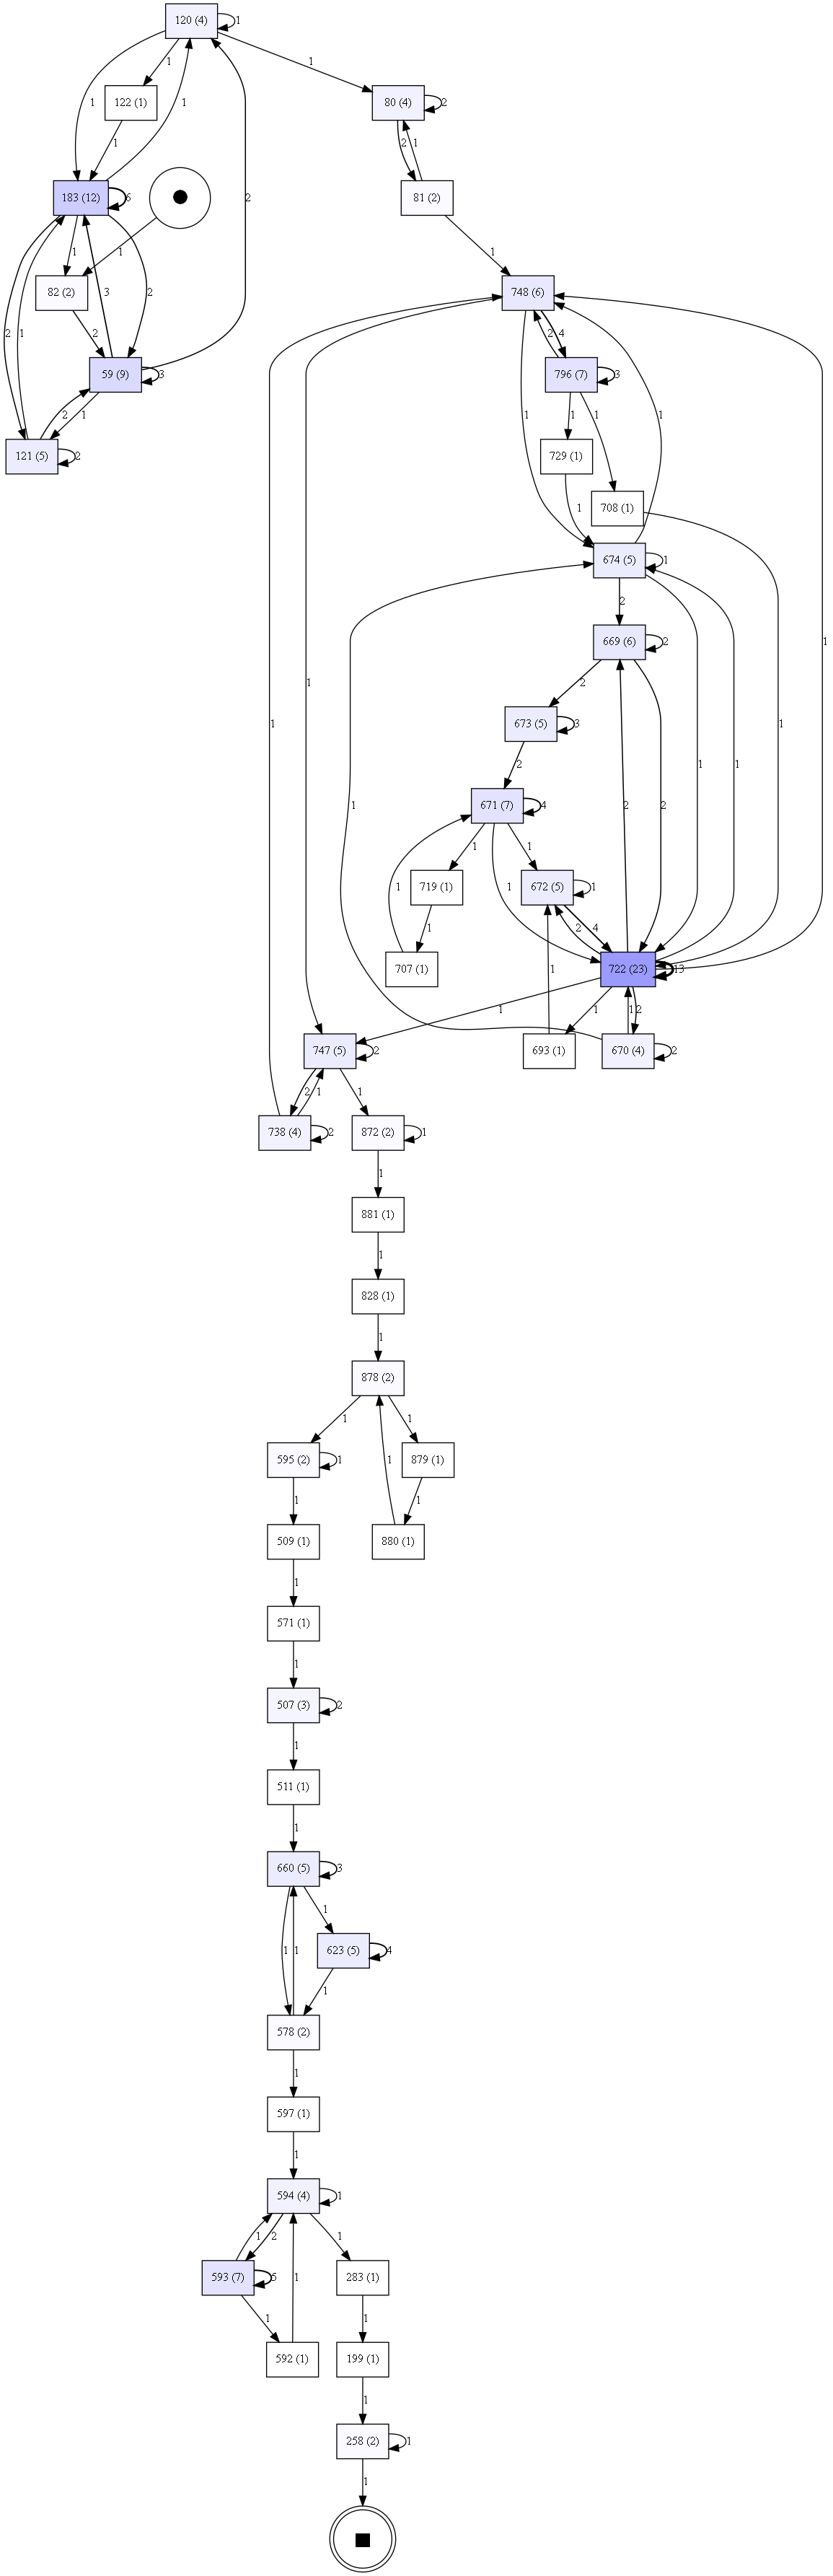

In [357]:
# Global Search

log_xes_GS = pm4py.read_xes("log_csv_GS.xes")
dfg, start_activities_GS, end_activities_GS = pm4py.discover_dfg(log_xes_GS)
pm4py.vis.view_dfg(dfg, start_activities_GS, end_activities_GS)

parsing log, completed traces :: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]
C:\Users\la1949\AppData\Local\Temp\ipykernel_11236\2212999675.py:4: DeprecatedWarning: discover_dfg is deprecated as of 2.3.0 and will be removed in 2.4.0. this method will be replaced by the discover_dfg_typed function(). Please adapt your code to use pm4py.discover_dfg_typed()
  dfg, start_activities_GI, end_activities_GI = pm4py.discover_dfg(log_xes_GI)


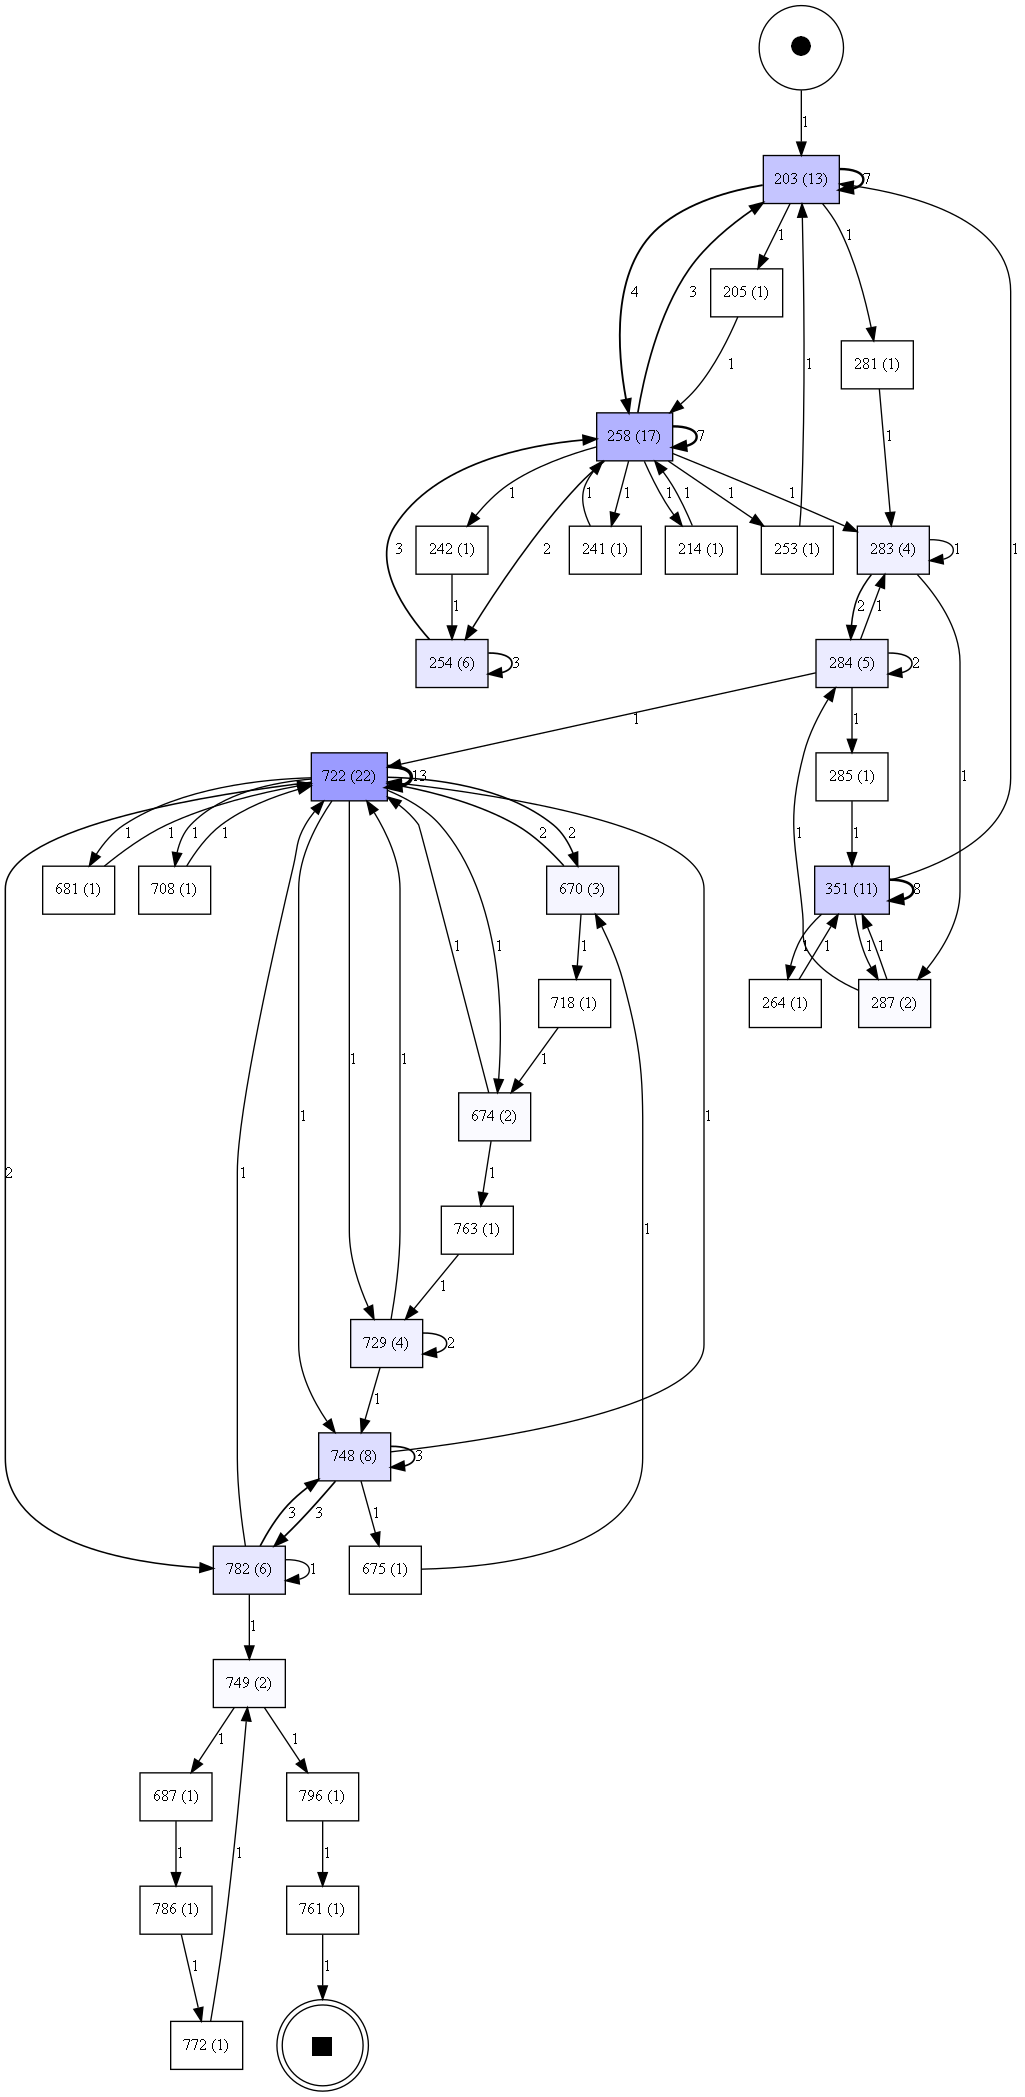

In [361]:
# Global Inference

log_xes_GI = pm4py.read_xes("log_csv_GI.xes")
dfg, start_activities_GI, end_activities_GI = pm4py.discover_dfg(log_xes_GI)
pm4py.vis.view_dfg(dfg, start_activities_GI, end_activities_GI)